In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flo-data/flo_data_20k.csv


## Business Problem

A company needs to segment customers using customer shopping data.

## Dataset 
* master_id: Unique customer ID
* order_channel: Used channel for shopping(Android, iOS, Desktop, Mobile)
* last_order_channel: The channel where the most recent purchase was made
* first_order_date: Date of the customer's first purchase
* last_order_date: Date of the customer's last purchase
* last_order_date_online: The date of the last purchase made by the customer on the online platform
* last_order_date_offline: The date of the last purchase made by the customer on the offline platform
* order_num_total_ever_online: The total number of purchases made by the customer on the online platform
* order_num_total_ever_offline: The total number of purchases made by the customer on the offline platform
* customer_value_total_ever_online: The total payment by the customer for their online shopping
* customer_value_total_ever_offline: The total payment by the customer for their offline shopping
* interested_in_categories_12: List of categories the customer has shopped in the last 12 months

## Method:

**There are many ways to do customer segmentation. One of these ways is the RFM metric. It enables customers to be divided into groups based on their purchasing habits and to develop strategies specific to these groups. Also RFM provides the opportunity to take data-based actions on many topics for crm studies.**<br>
**The RFM model is based on three quantitative factors:**
* Recency: How recently a customer has made a purchase.
* Frequency: How often a customer makes a purchase.
* Monetary Value: How much money a customer spends on purchases.

In [2]:
import pandas as pd
import datetime as dt

In [3]:
df = pd.read_csv("/kaggle/input/flo-data/flo_data_20k.csv")
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR]


**First of all, we are doing a preview for the dataset.**

In [4]:
def check_df(dataframe, head=10):
    print("##################### Shape #####################")
    print(dataframe.shape)

    print("##################### Types #####################")
    print(dataframe.dtypes)

    print("##################### Head #####################")
    print(dataframe.head(head))

    print("##################### Tail #####################")
    print(dataframe.tail(head))

    print("##################### is null? #####################")
    print(dataframe.isnull().sum())

    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.25, 0.50, 0.75, 0.99, 1]).T)
    print(dataframe.describe().T)


check_df(df)

##################### Shape #####################
(19945, 12)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### Head #####################
                              master_id order_channel last_order_channel  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile   
2  69b69676-1a40-11ea-941b-000d3a38a36f   Android App    

**Let's create new variables for the total number of purchases and spending for each customer.**

In [5]:
df["order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]

df["customer_value_total_price"] = df["customer_value_total_ever_online"] + df["customer_value_total_ever_offline"]

df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,order_num_total,customer_value_total_price
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],5.0,939.37
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.0,2013.55
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",5.0,585.32
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",2.0,121.97
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],2.0,209.98


**Let's convert the variables expressed in date format to date time.**

In [6]:
for t in df.columns:
    if "date" in t:
        df[t] = df[t].apply(pd.to_datetime)

**See the distribution of the number of customers in the shopping channels, the total number of products purchased and the total expenditures.**

In [7]:
df.groupby("order_channel").agg({"master_id": "count",
                                "order_num_total": "sum",
                                "customer_value_total_price": "sum"}).head(10)

,master_id,order_num_total,customer_value_total_price
order_channel,,,
Android App,9495,52269.0,7819062.76
Desktop,2735,10920.0,1610321.46
Ios App,2833,15351.0,2525999.93
Mobile,4882,21679.0,3028183.16


**Rank the top 10 customers with the highest profits.**

In [8]:
df.groupby(["master_id"]).agg({"customer_value_total_price": "sum"}).sort_values("customer_value_total_price", ascending=False).head(10)

,customer_value_total_price
master_id,
5d1c466a-9cfd-11e9-9897-000d3a38a36f,45905.10
d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,36818.29
73fd19aa-9e37-11e9-9897-000d3a38a36f,33918.10
7137a5c0-7aad-11ea-8f20-000d3a38a36f,31227.41
47a642fe-975b-11eb-8c2a-000d3a38a36f,20706.34
a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,18443.57
d696c654-2633-11ea-8e1c-000d3a38a36f,16918.57
fef57ffa-aae6-11e9-a2fc-000d3a38a36f,12726.10
cba59206-9dd1-11e9-9897-000d3a38a36f,12282.24


**Rank the top 10 customers with the highest number of orders.**

In [9]:
df.groupby(["master_id"]).agg({"order_num_total": "sum"}).sort_values("order_num_total", ascending=False).head(10)

,order_num_total
master_id,
5d1c466a-9cfd-11e9-9897-000d3a38a36f,202.0
cba59206-9dd1-11e9-9897-000d3a38a36f,131.0
a57f4302-b1a8-11e9-89fa-000d3a38a36f,111.0
fdbe8304-a7ab-11e9-a2fc-000d3a38a36f,88.0
329968c6-a0e2-11e9-a2fc-000d3a38a36f,83.0
73fd19aa-9e37-11e9-9897-000d3a38a36f,82.0
44d032ee-a0d4-11e9-a2fc-000d3a38a36f,77.0
b27e241a-a901-11e9-a2fc-000d3a38a36f,75.0
d696c654-2633-11ea-8e1c-000d3a38a36f,70.0


**Calculate Recency, Frequency and Monetary metrics for the customer and change the names of the metrics you created to recency, frequency and monetary.**

In [10]:
df["last_order_date"].max()

today_date = dt.datetime(2021,6,1)

rfm = df.groupby("master_id").agg({"last_order_date": lambda last_order_date: (today_date - last_order_date.max()).days,
                                     "order_num_total": lambda order_num_total: order_num_total,
                                     "customer_value_total_price": lambda customer_value_total_price: customer_value_total_price.sum()})

rfm.head()

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,19945.0,134.458360,103.281149,2.00,43.00,111.00,202.00,367.0
Frequency,19945.0,5.024768,4.742707,2.00,3.00,4.00,6.00,202.0
Monetary,19945.0,751.244287,895.402173,44.98,339.98,545.27,897.78,45905.1


**Assign your calculated metrics to a variable named rfm**

In [11]:
rfm["recency_score"] = pd.qcut(rfm["Recency"], 5, labels= [5, 4, 3, 2, 1])
rfm["monetary_score"] = pd.qcut(rfm["Monetary"], 5, labels= [1, 2, 3, 4, 5])
rfm["frequency_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels= [1, 2, 3, 4, 5])

rfm["RF_SCORE"] = (rfm["recency_score"].astype(str)+
                    rfm["frequency_score"].astype(str))

rfm.describe().T
rfm.head()

,Recency,Frequency,Monetary,recency_score,monetary_score,frequency_score,RF_SCORE
master_id,,,,,,,
00016786-2f5a-11ea-bb80-000d3a38a36f,10,5.0,776.07,5,4,4,54
00034aaa-a838-11e9-a2fc-000d3a38a36f,298,3.0,269.47,1,1,2,12
000be838-85df-11ea-a90b-000d3a38a36f,213,4.0,722.69,2,4,3,23
000c1fe2-a8b7-11ea-8479-000d3a38a36f,27,7.0,874.16,5,4,4,54
000f5e3e-9dde-11ea-80cd-000d3a38a36f,20,7.0,1620.33,5,5,4,54


**Creation of segment definitions for RFM scores.**

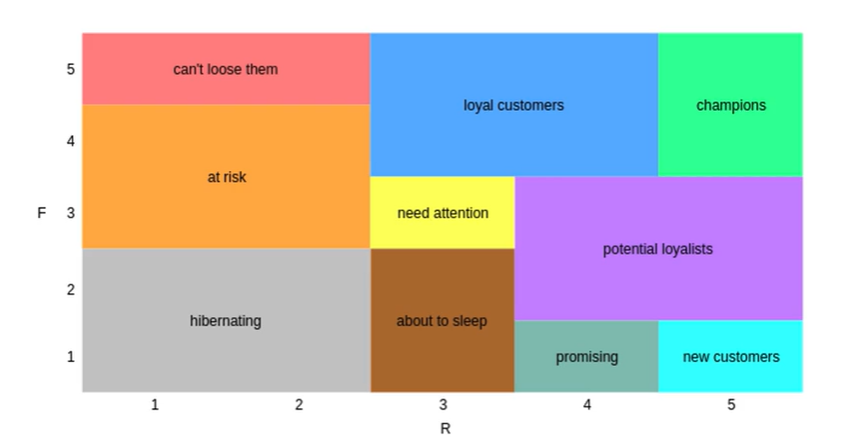

In [12]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm["segment"] = rfm["RF_SCORE"].replace(seg_map, regex=True)

**Examine the recency, frequency and monetary mean of the segments.**

In [13]:
rfm[["segment", "Recency", "Frequency", "Monetary"]].groupby("segment").agg(["mean", "count"])


Recency        Frequency           Monetary      
                           mean count       mean count         mean count
segment                                                                  
about_to_sleep       114.031649  1643   2.406573  1643   361.649373  1643
at_Risk              242.328997  3152   4.470178  3152   648.325038  3152
cant_loose           235.159129  1194  10.716918  1194  1481.652446  1194
champions             17.142187  1920   8.965104  1920  1410.708938  1920
hibernating          247.426303  3589   2.391474  3589   362.583299  3589
loyal_customers       82.557926  3375   8.356444  3375  1216.257224  3375
need_attention       113.037221   806   3.739454   806   553.436638   806
new_customers         17.976226   673   2.000000   673   344.049495   673
potential_loyalists   36.869744  2925   3.310769  2925   533.741344  2925
promising             58.694611   668   2.000000   668   334.153338   668

**Next, let's look at the "loyal_customer". After identifying loyal customers, actions should be determined for these customers.<br>
For example,**
* We can launch a special campaign for these customers,
* Send a special e-mail to promote new products.  

In [14]:
rfm[rfm["RF_SCORE"] == "45"]

,Recency,Frequency,Monetary,recency_score,monetary_score,frequency_score,RF_SCORE,segment
master_id,,,,,,,,
00534fe4-a6b4-11e9-a2fc-000d3a38a36f,63,16.0,800.59,4,4,5,45,loyal_customers
006633b6-a6b9-11e9-a2fc-000d3a38a36f,61,19.0,2050.50,4,5,5,45,loyal_customers
00f037ce-9fa6-11e9-a2fc-000d3a38a36f,58,18.0,1896.03,4,5,5,45,loyal_customers
02438ab8-b171-11e9-89fa-000d3a38a36f,35,10.0,895.26,4,4,5,45,loyal_customers
024b87da-9d4f-11e9-9897-000d3a38a36f,81,26.0,2045.01,4,5,5,45,loyal_customers
...,...,...,...,...,...,...,...,...
fefb852a-2580-11ea-b1c8-000d3a38a36f,36,7.0,1997.67,4,5,5,45,loyal_customers
fefdcdda-a80d-11e9-a2fc-000d3a38a36f,48,8.0,897.40,4,4,5,45,loyal_customers
ff0732ea-b158-11e9-9757-000d3a38a36f,46,9.0,1031.69,4,5,5,45,loyal_customers


**Also look at segments for risky customers. Here, we can develop different studies by taking action with the relevant departments in order not to lose these customers.**

In [15]:
rfm[rfm["segment"] == "at_Risk"]

,Recency,Frequency,Monetary,recency_score,monetary_score,frequency_score,RF_SCORE,segment
master_id,,,,,,,,
000be838-85df-11ea-a90b-000d3a38a36f,213,4.0,722.69,2,4,3,23,at_Risk
0025f17c-eeaf-11ea-bb5a-000d3a38a36f,186,4.0,791.97,2,4,3,23,at_Risk
00266a76-312c-11ea-b884-000d3a38a36f,184,7.0,1249.58,2,5,4,24,at_Risk
00425f66-5b51-11ea-96d8-000d3a38a36f,199,4.0,419.96,2,2,3,23,at_Risk
00596df0-abca-11e9-a2fc-000d3a38a36f,213,4.0,1408.36,2,5,3,23,at_Risk
...,...,...,...,...,...,...,...,...
ffe0b356-5bf0-11ea-93ed-000d3a38a36f,232,3.0,327.97,2,2,3,23,at_Risk
ffec351a-2a76-11ea-b3a7-000d3a38a36f,337,5.0,629.93,1,3,4,14,at_Risk
fff1db94-afd9-11ea-b736-000d3a38a36f,183,5.0,796.87,2,4,4,24,at_Risk
